<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Logo_UTFSM.png" width="200" alt="utfsm-logo" align="left"/>

# MAT281
### Aplicaciones de la Matemática en la Ingeniería

## Módulo 04
## Clase 03: Clasificación

## Objetivos

* Conocer la idea detrás de los algoritmos de clasificación.
* Realizar y utilizar implementaciones algorítmicas.

## Contenidos
* [Motivación](#intro)
* [Regresión Logística](#logistic_regression)
* [Implementación](#implementation)

<a id='intro'></a>

## Motivación

Para comprender mejor los algoritmos de clasificación se comenzará con un ejemplo.

**Space Shuttle Challege**

28 Junio 1986. A pesar de existir evidencia de funcionamiento defectuoso, se da luz verde al lanzamiento.

<img src="images/Challenger1.gif" alt="" width="600px" align="middle"/>

A los 73 segundos de vuelo, el transbordador espacial explota, matando a los 7 pasajeros.

<img src="images/Challenger2.jpg" alt="" width="600px" align="middle"/>

### Exploración de datos

Como parte del debriefing del accidente, se obtuvieron los siguientes datos

In [1]:
!head data/Challenger.txt -n 15

"Temp"	"BadRings"
53	3
56	1
57	1
63	0
66	0
67	0
67	0
67	0
68	0
69	0
70	0
70	1
70	1
70	1


Es posible graficarlos para tener una idea general de estos.

In [2]:
import numpy as np
import pandas as pd
import altair as alt

alt.themes.enable('opaque')  # Para quienes utilizan temas oscuros en Jupyter Lab/Notebook

ThemeRegistry.enable('opaque')

In [6]:
challenger = pd.DataFrame(
    np.loadtxt("data/Challenger.txt", skiprows=1).astype(np.int),
    columns=["temp_f", "nm_bad_rings"]
)
challenger.head()

,temp_f,nm_bad_rings
0,53,3
1,56,1
2,57,1
3,63,0
4,66,0


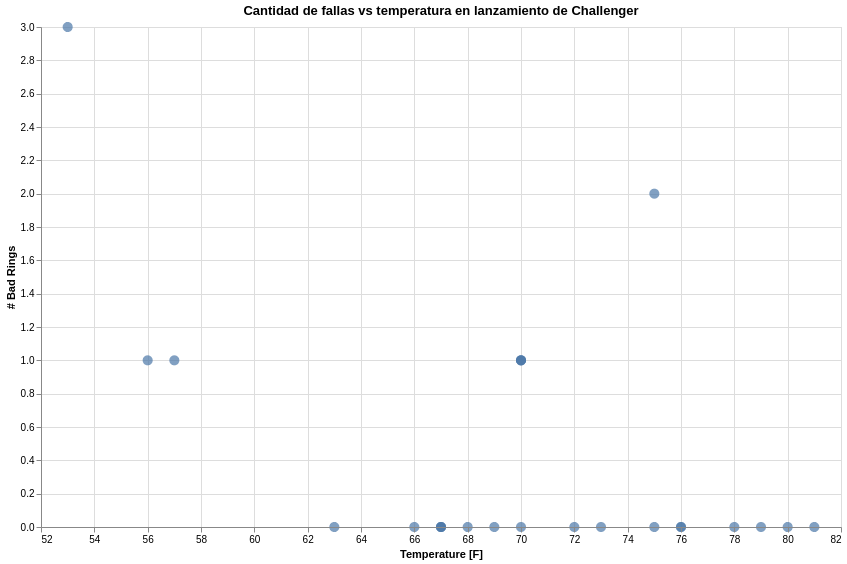

In [7]:
alt.Chart(challenger).mark_circle(size=100).encode(
    x=alt.X("temp_f", scale=alt.Scale(zero=False), title="Temperature [F]"),
    y=alt.Y("nm_bad_rings", title="# Bad Rings")
).properties(
    title="Cantidad de fallas vs temperatura en lanzamiento de Challenger",
    width=800,
    height=500
)

Nos gustaría saber en qué condiciones se produce accidente. No nos importa el número de fallas, sólo si existe falla o no.

In [8]:
# Un poco de procesamiento de datos
challenger = challenger.assign(
    temp_c=lambda x: ((x["temp_f"] - 32.) / 1.8).round(2),
    is_failure=lambda x: x["nm_bad_rings"].ne(0).astype(np.int),
    ds_failure=lambda x: x["is_failure"].map({1: "Falla", 0:"Éxito"})
)

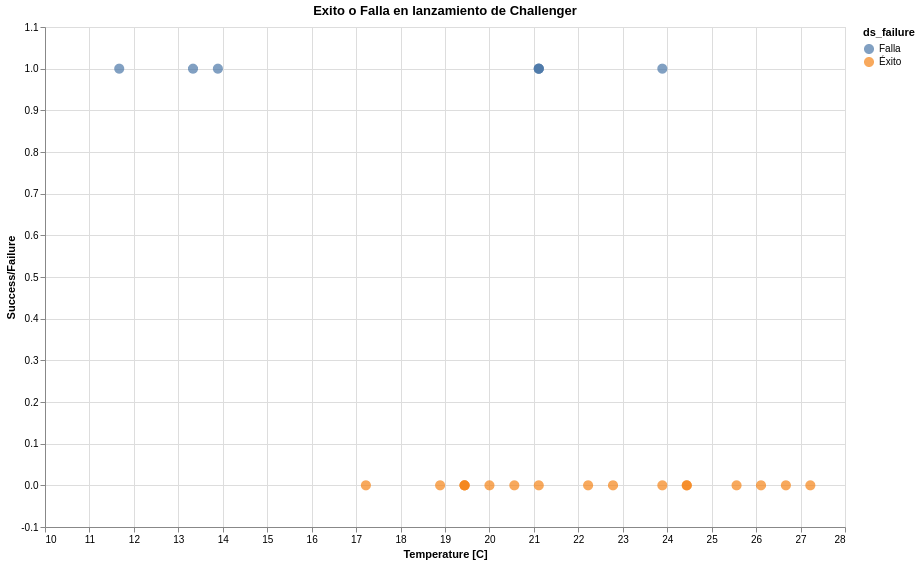

In [9]:
failure_chart = alt.Chart(challenger).mark_circle(size=100).encode(
    x=alt.X("temp_c:Q", scale=alt.Scale(zero=False), title="Temperature [C]"),
    y=alt.Y("is_failure:Q", scale=alt.Scale(padding=0.5), title="Success/Failure"),
    color="ds_failure:N"
).properties(
    title="Exito o Falla en lanzamiento de Challenger",
    width=800,
    height=500
)

failure_chart

<a id='logistic_regression'></a>

## Regresión Logística

Recordemos que la **Regresión Lineal** considera un modelo de la siguiente forma:

$$ Y \approx X \theta $$

donde 
$$
Y = \begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}
\qquad , \qquad
X = \begin{bmatrix} 
1 & x^{(1)}_1 & \dots & x^{(1)}_n \\ 
1 & x^{(2)}_1 & \dots & x^{(2)}_n \\
\vdots & \vdots & & \vdots \\
1 & x^{(m)}_1 & \dots & x^{(m)}_n
\end{bmatrix}
\qquad y \qquad
\theta = \begin{bmatrix}\theta_1 \\ \theta_2 \\ \vdots \\ \theta_m\end{bmatrix}
$$

y que se  entrenar una función lineal

$$h_{\theta}(x) = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$$

deforma que se minimice

$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$


La **Regresión Logística** busca entrenar la función 

$$h_{\theta}(x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_1 + ... + \theta_n x_n)}}$$

de forma que se minimice

$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

Es decir, el objetivo es encontrar un _"buen"_ vector $\theta$ de modo que

$$Y \approx g(X \theta)$$,

en donde $g(z)$ es la función sigmoide (_sigmoid function_),

$$g(z) = \frac{1}{1+e^{-z}}$$

### Función Sigmoide

In [10]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

In [12]:
z = np.linspace(-5,5,100)
sigmoid_df = pd.DataFrame(
    {
        "z": z,
        "sigmoid(z)": sigmoid(z),
        "sigmoid(z*2)": sigmoid(z * 2),
        "sigmoid(z-2)": sigmoid(z - 2),
    }
)
sigmoid_df = pd.melt(
    sigmoid_df,
    id_vars="z",
    value_vars=["sigmoid(z)", "sigmoid(z*2)", "sigmoid(z-2)"],
    var_name="sigmoid_function",
    value_name="value"
)
sigmoid_df.head()

,z,sigmoid_function,value
0,-5.00000,sigmoid(z),0.006693
1,-4.89899,sigmoid(z),0.007399
2,-4.79798,sigmoid(z),0.008179
3,-4.69697,sigmoid(z),0.009040
4,-4.59596,sigmoid(z),0.009992


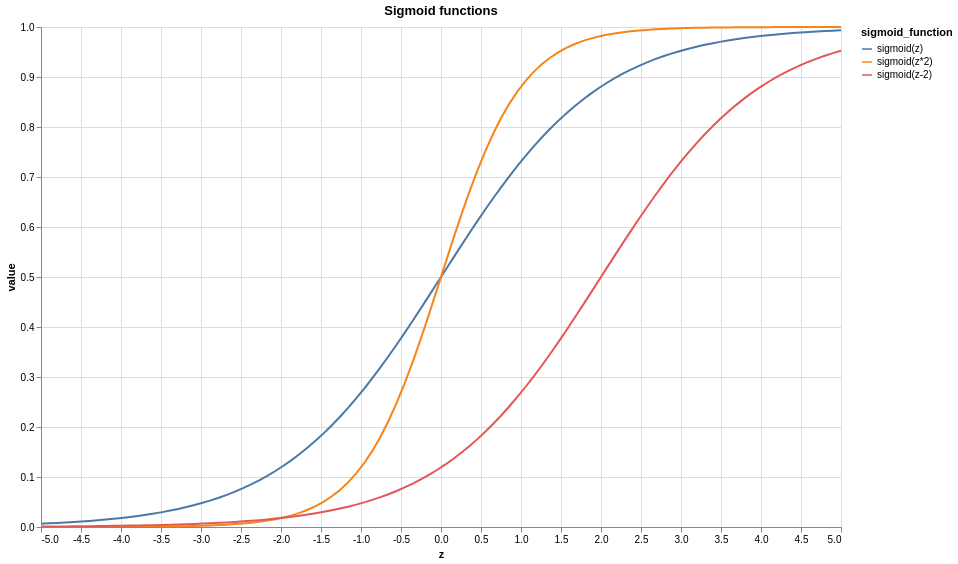

In [13]:
alt.Chart(sigmoid_df).mark_line().encode(
    x="z:Q",
    y="value:Q",
    color="sigmoid_function:N"
).properties(
    title="Sigmoid functions",
    width=800,
    height=500
)

La función
sigmoide $g(z) = (1+e^{-z})^{-1}$ tiene la siguiente propiedad:

$$g'(z) =  g(z)(1-g(z))$$

"Demostración":

$$\begin{aligned}
g'(z) &= \frac{-1}{(1+e^{-z})^2} (-e^{-z}) \\
      &= \frac{e^{-z}}{(1+e^{-z})^2} \\
      &= \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} \\
      &= \frac{1}{1+e^{-z}} \left(1 - \frac{1}{1+e^{-z}} \right) \\
      &= g(z)(1-g(z))\end{aligned}$$

In [14]:
def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

sigmoid_dz_df = (
    pd.DataFrame(
        {
            "z": z,
            "sigmoid(z)": sigmoid(z),
            "d_sigmoid(z)/dz": d_sigmoid(z)
        }
    )
    .melt(
        id_vars="z",
        value_vars=["sigmoid(z)", "d_sigmoid(z)/dz"],
        var_name="function"
    )
)
sigmoid_dz_df.head()

,z,function,value
0,-5.00000,sigmoid(z),0.006693
1,-4.89899,sigmoid(z),0.007399
2,-4.79798,sigmoid(z),0.008179
3,-4.69697,sigmoid(z),0.009040
4,-4.59596,sigmoid(z),0.009992


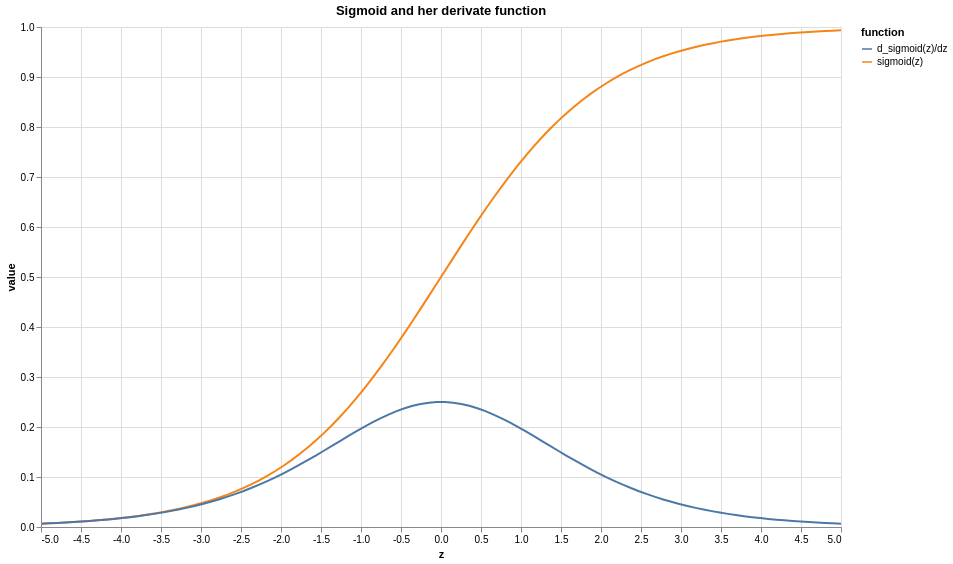

In [15]:
alt.Chart(sigmoid_dz_df).mark_line().encode(
    x="z:Q",
    y="value:Q",
    color="function:N"
).properties(
    title="Sigmoid and her derivate function",
    width=800,
    height=500
)

¡Es perfecta para encontrar un punto de corte y clasificar de manera binaria!

<a id='implementation'></a>

## Implementación

### Aproximación Ingenieril

¿Cómo podemos reutilizar lo que conocemos de regresión lineal?

Si buscamos minimizar
$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$
Podemos calcular el gradiente y luego utilizar el método del máximo
descenso para obtener $\theta$.



El cálculo del gradiente es directo:

$$\begin{aligned}
\frac{\partial J(\theta)}{\partial \theta_k}
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) \frac{\partial}{\partial \theta_k} h_{\theta}(x^{(i)}) \\
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) \frac{\partial}{\partial \theta_k} g(\theta^T x^{(i)}) \\
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) h_{\theta}(x^{(i)}) \left(1-h_{\theta}(x^{(i)})\right) \frac{\partial}{\partial \theta_k} (\theta^T x^{(i)}) \\
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) h_{\theta}(x^{(i)}) \left(1-h_{\theta}(x^{(i)})\right) x^{(i)}_k\end{aligned}$$


¿Hay alguna forma de escribir todo esto de manera matricial? Recordemos
que si las componentes eran

$$\begin{aligned}
\sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) x^{(i)}_k = \sum_{i=1}^{m}  x^{(i)}_k \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)\end{aligned}$$

podíamos escribirlo vectorialmente como $$X^T (X\theta - Y)$$



Luego, para

$$\begin{aligned}
\frac{\partial J(\theta)}{\partial \theta_k}
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) h_{\theta}(x^{(i)}) \left(1-h_{\theta}(x^{(i)})\right) x^{(i)}_k \\
&= \sum_{i=1}^{m}  x^{(i)}_k \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) h_{\theta}(x^{(i)}) \left(1-h_{\theta}(x^{(i)})\right)\end{aligned}$$

podemos escribirlo vectorialmente como
$$\nabla_{\theta} J(\theta) = X^T  \Big[ (g(X\theta) - Y) \odot g(X\theta) \odot (1-g(X\theta)) \Big]$$
donde $\odot$ es la multiplicación elemento a elemento (element-wise).

**Observación crucial:**
$$\nabla_{\theta} J(\theta) = X^T  \Big[ (g(X\theta) - Y) \odot g(X\theta) \odot (1-g(X\theta)) \Big]$$
no permite construir un sistema lineal para $\theta$, por lo cual sólo
podemos resolver iterativamente.


Por
lo tanto tenemos el algoritmo

$$\begin{aligned}
\theta^{(n+1)} & = \theta^{(n)} - \alpha \nabla_{\theta} J(\theta^{(n)}) \\
\nabla_{\theta} J(\theta) &= X^T  \Big[ (g(X\theta) - Y) \odot g(X\theta) \odot (1-g(X\theta)) \Big]\end{aligned}$$



El código sería el siguiente:

In [16]:
def norm2_error_logistic_regression(X, Y, theta0, tol=1E-6):
    converged = False
    alpha = 0.01 / len(Y)
    theta = theta0
    while not converged:
        H = sigmoid(np.dot(X, theta))
        gradient = np.dot(X.T, (H - Y) * H * (1 - H))
        new_theta = theta - alpha * gradient
        converged = np.linalg.norm(theta - new_theta) < tol * np.linalg.norm(theta) 
        theta = new_theta
    return theta

### Interpretación Probabilística

¿Es la derivación anterior
probabilísticamente correcta?

Asumamos que la pertenencia a los grupos está dado por

$$\begin{aligned}
\mathbb{P}[y = 1| \ x ; \theta ] & = h_\theta(x) \\
\mathbb{P}[y = 0| \ x ; \theta ] & = 1 - h_\theta(x)\end{aligned}$$

Esto es, una distribución de Bernoulli con $p=h_\theta(x)$.\
Las expresiones anteriores pueden escribirse de manera más compacta como

$$\begin{aligned}
\mathbb{P}[y | \ x ; \theta ] & = (h_\theta(x))^y (1 - h_\theta(x))^{(1-y)} \\\end{aligned}$$


La función de verosimilitud $L(\theta)$ nos
permite entender que tan probable es encontrar los datos observados,
para una elección del parámetro $\theta$.

$$\begin{aligned}
L(\theta) 
&= \prod_{i=1}^{m} \mathbb{P}[y^{(i)}| x^{(i)}; \theta ] \\
&= \prod_{i=1}^{m} \Big(h_{\theta}(x^{(i)})\Big)^{y^{(i)}} \Big(1 - h_\theta(x^{(i)})\Big)^{(1-y^{(i)})}\end{aligned}$$

Nos gustaría encontrar el parámetro $\theta$ que más probablemente haya
generado los datos observados, es decir, el parámetro $\theta$ que
maximiza la función de verosimilitud.


Calculamos la log-verosimilitud:

$$\begin{aligned}
l(\theta) 
&= \log L(\theta) \\
&= \log \prod_{i=1}^{m} (h_\theta(x^{(i)}))^{y^{(i)}} (1 - h_\theta(x^{(i)}))^{(1-y^{(i)})} \\
&= \sum_{i=1}^{m} y^{(i)}\log (h_\theta(x^{(i)})) + (1-y^{(i)}) \log (1 - h_\theta(x^{(i)}))\end{aligned}$$

No existe una fórmula cerrada que nos permita obtener el máximo de la
log-verosimitud. Pero podemos utilizar nuevamente el método del
gradiente máximo.


Recordemos que si

$$\begin{aligned}
g(z) = \frac{1}{1+e^{-z}}\end{aligned}$$

Entonces

$$\begin{aligned}
g'(z) &= g(z)(1-g(z))\end{aligned}$$

y luego tenemos que

$$\begin{aligned}
\frac{\partial}{\partial \theta_k} h_\theta(x) &= h_\theta(x) (1-h_\theta(x)) x_k\end{aligned}$$


$$\begin{aligned}
\frac{\partial}{\partial \theta_k} l(\theta) &=
\frac{\partial}{\partial \theta_k}  \sum_{i=1}^{m} y^{(i)}\log (h_\theta(x^{(i)})) + (1-y^{(i)}) \log (1 - h_\theta(x^{(i)})) \\
&= \sum_{i=1}^{m} y^{(i)}\frac{\partial}{\partial \theta_k}   \log (h_\theta(x^{(i)})) + (1-y^{(i)}) \frac{\partial}{\partial \theta_k}  \log (1 - h_\theta(x^{(i)})) \\
&= \sum_{i=1}^{m} y^{(i)}\frac{1}{h_\theta(x^{(i)})}\frac{\partial h_\theta(x^{(i)})}{\partial \theta_k} 
+ (1-y^{(i)}) \frac{1}{1 - h_\theta(x^{(i)})} \frac{\partial (1-h_\theta(x^{(i)}))}{\partial \theta_k} \\
&= \sum_{i=1}^{m} y^{(i)}(1-h_\theta(x^{(i)})) x^{(i)}- (1-y^{(i)}) h_\theta(x^{(i)}) x^{(i)}\\
&= \sum_{i=1}^{m} y^{(i)}x^{(i)}- y^{(i)}h_\theta(x^{(i)}) x^{(i)}- h_\theta(x^{(i)}) x^{(i)}+ y^{(i)}h_\theta(x^{(i)}) x^{(i)}\\
&= \sum_{i=1}^{m} (y^{(i)}-h_\theta(x^{(i)})) x^{(i)}\end{aligned}$$


Es decir, para maximizar la log-verosimilitud
obtenemos igual que para la regresión lineal:

$$\begin{aligned}
\theta^{(n+1)} & = \theta^{(n)} - \alpha \nabla_{\theta} l(\theta^{(n)}) \\
\frac{\partial l(\theta)}{\partial \theta_k}
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) x^{(i)}_k\end{aligned}$$

Aunque, en el caso de regresión logística, se tiene
$h_\theta(x)=1/(1+e^{-x^T\theta})$

In [17]:
def likelihood_logistic_regression(X, Y, theta0, tol=1E-6):
    converged = False
    alpha = 0.01 / len(Y)
    theta = theta0
    while not converged:
        H = sigmoid(np.dot(X, theta))
        gradient = np.dot(X.T, H - Y)
        new_theta = theta - alpha * gradient
        converged = np.linalg.norm(theta - new_theta) < tol * np.linalg.norm(theta) 
        theta = new_theta
    return theta

### Aplicación a los datos del Challenger

Recordemos que los datos son:

In [18]:
challenger.head()

,temp_f,nm_bad_rings,temp_c,is_failure,ds_failure
0,53,3,11.67,1,Falla
1,56,1,13.33,1,Falla
2,57,1,13.89,1,Falla
3,63,0,17.22,0,Éxito
4,66,0,18.89,0,Éxito


Generamos la matriz de diseño $X$ y el vector de respuestas $Y$ a partir del dataframe anterior.

In [19]:
X = challenger.loc[:, ["temp_c"]].assign(intercept=1)[["intercept", "temp_c"]].values
y = challenger.loc[:, ["is_failure"]].values
theta_0 = (y.mean() / X.mean(axis=0)).reshape(2, 1)

In [20]:
print(f"theta_0 =\n {theta_0}\n")
theta_J = norm2_error_logistic_regression(X, y, theta_0)
print(f"theta_J =\n {theta_J}\n")
theta_l = likelihood_logistic_regression(X, y, theta_0)
print(f"theta_l = \n{theta_l}")

theta_0 =
 [[0.29166667]
 [0.01384658]]

theta_J =
 [[ 4.47224507]
 [-0.26847216]]

theta_l = 
[[ 5.27415368]
 [-0.30262323]]


In [21]:
sigmoid(np.dot(X, theta_l)).flatten()

array([0.85100948, 0.77559639, 0.74473325, 0.51574021, 0.39116945,
       0.35232342, 0.35232342, 0.35232342, 0.31468403, 0.27933151,
       0.24708448, 0.24708448, 0.24708448, 0.24708448, 0.18998087,
       0.16525956, 0.12395322, 0.12395322, 0.10698086, 0.10698086,
       0.07864538, 0.06739953, 0.05749692, 0.04911397])

In [22]:
predict_df = (
    pd.DataFrame(
        {
            "temp_c": X[:, 1],
            "norm_2_error_prediction": sigmoid(np.dot(X, theta_J)).flatten(),
            "likelihood_prediction": sigmoid(np.dot(X, theta_l)).flatten()
        }
    )
    .melt(
        id_vars="temp_c",
        value_vars=["norm_2_error_prediction", "likelihood_prediction"],
        var_name="prediction"
    )
)
predict_df.head()

,temp_c,prediction,value
0,11.67,norm_2_error_prediction,0.792354
1,13.33,norm_2_error_prediction,0.709614
2,13.89,norm_2_error_prediction,0.677688
3,17.22,norm_2_error_prediction,0.462360
4,18.89,norm_2_error_prediction,0.354528


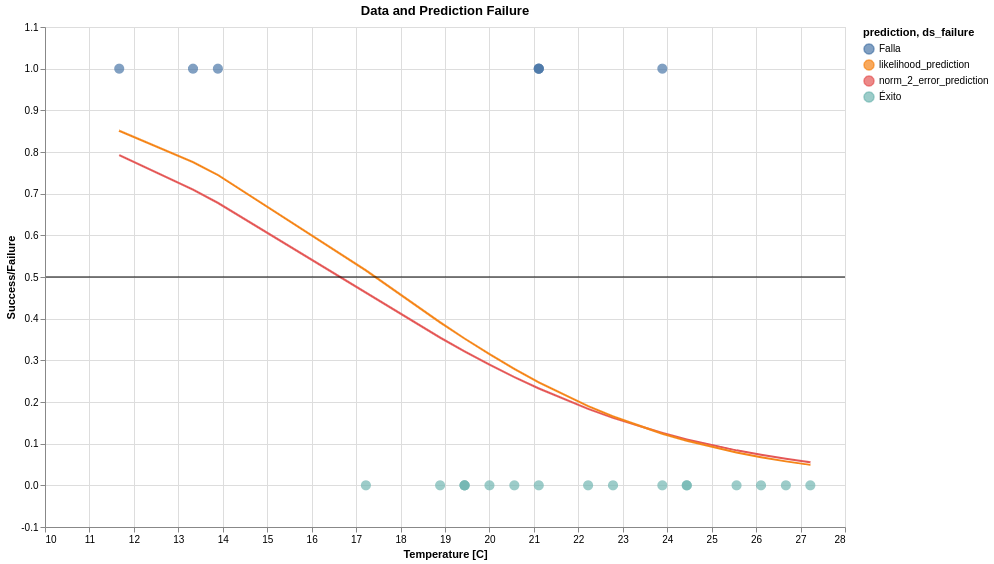

In [23]:
prediction_chart = alt.Chart(predict_df).mark_line().encode(
    x=alt.X("temp_c:Q", scale=alt.Scale(zero=False), title="Temperature [C]"),
    y=alt.Y("value:Q", scale=alt.Scale(padding=0.5)),
    color="prediction:N"
)

rule = alt.Chart(pd.DataFrame({"decision_boundary": [0.5]})).mark_rule().encode(y='decision_boundary')

(prediction_chart + failure_chart + rule).properties(title="Data and Prediction Failure")

### Implementación scikit-learn

Scikit-learn tiene su propia implementación de Regresión Logística al igual que la Regresión Lineal. A medida que vayas leyendo e interiorizándote en la librería verás que tratan de mantener una sintaxis y API consistente en los distintos objetos y métodos.

In [35]:
from sklearn.linear_model import LogisticRegression

In [42]:
X = challenger[["temp_c"]].values
y = challenger["is_failure"].values

# Fitting the model
Logit = LogisticRegression(solver="lbfgs")
Logit.fit(X, y)

# Obtain the coefficients
print(Logit.intercept_, Logit.coef_ )

# Predicting values
y_pred = Logit.predict(X)

[5.25668668] [[-0.30158355]]


Procedamos a calcular la matriz de confusión.

Por definición, la matriz de confusión $C$ es tal que  $C_{i, j}$ es igual al número de observaciones conocidas en el grupo $i$ y predecidas en el grupo $j$.

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=[0, 1])
print(cm)

[[16  1]
 [ 4  3]]


In [44]:
pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

,0,1
0,16,1
1,4,3


In [46]:
from sklearn.metrics import plot_confusion_matrix  # New in scikit-learn 0.22

plot_confusion_matrix(Logit, X, y);

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/home/taz/miniconda3/envs/mat281/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

### Otro ejemplo: Iris Dataset

In [45]:
from sklearn import datasets 

iris = datasets.load_iris()
# print(iris.DESCR)

In [51]:
iris_df = (
    pd.DataFrame(iris.data, columns=iris.feature_names)
    .assign(
        target=iris.target,
        target_names=lambda x: x.target.map(dict(zip(range(3), iris.target_names)))
    )
)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [73]:
X = iris.data[:,  :2] # we only take the first two features.
y = iris.target

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 

# model
iris_lclf = LogisticRegression()
iris_lclf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
import matplotlib.pyplot as plt

%matplotlib inline

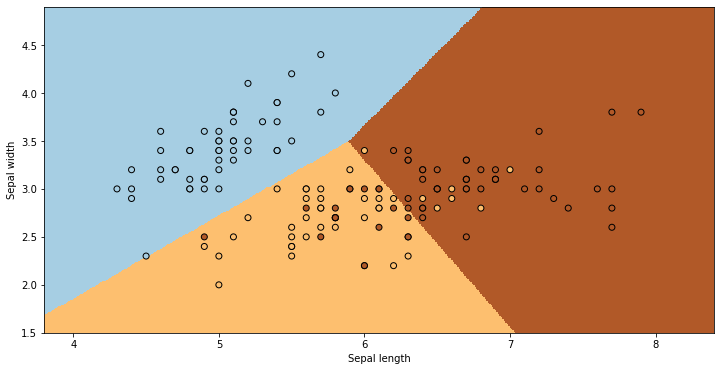

In [81]:
## Inspirado en https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py

plt.figure(figsize=(12, 6))

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .01  # step size in the mesh
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = iris_lclf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the real points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Por otro lado, la predicción debe hacerse con el set de test

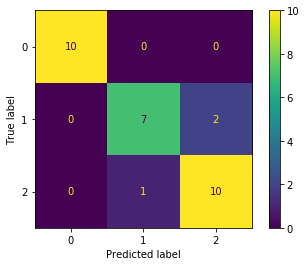

In [79]:
y_pred = iris_lclf.predict(X_test)
plot_confusion_matrix(iris_lclf, X_test, y_test);

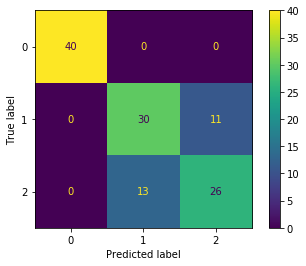

In [82]:
plot_confusion_matrix(iris_lclf, X_train, y_train);

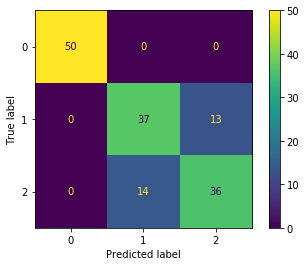

In [83]:
plot_confusion_matrix(iris_lclf, X, y);

¿Cuál es la forma correcta de escoger o medir el modelo? 

Lo descubrirás en la próxima clase.